In [13]:
# importing libraries and set standards
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import statistics as stat

plt.rcParams['figure.figsize'] = 21, 15
plt.rcParams['xtick.labelsize']=65
plt.rcParams['ytick.labelsize']=65
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.family'] = 'Arial'

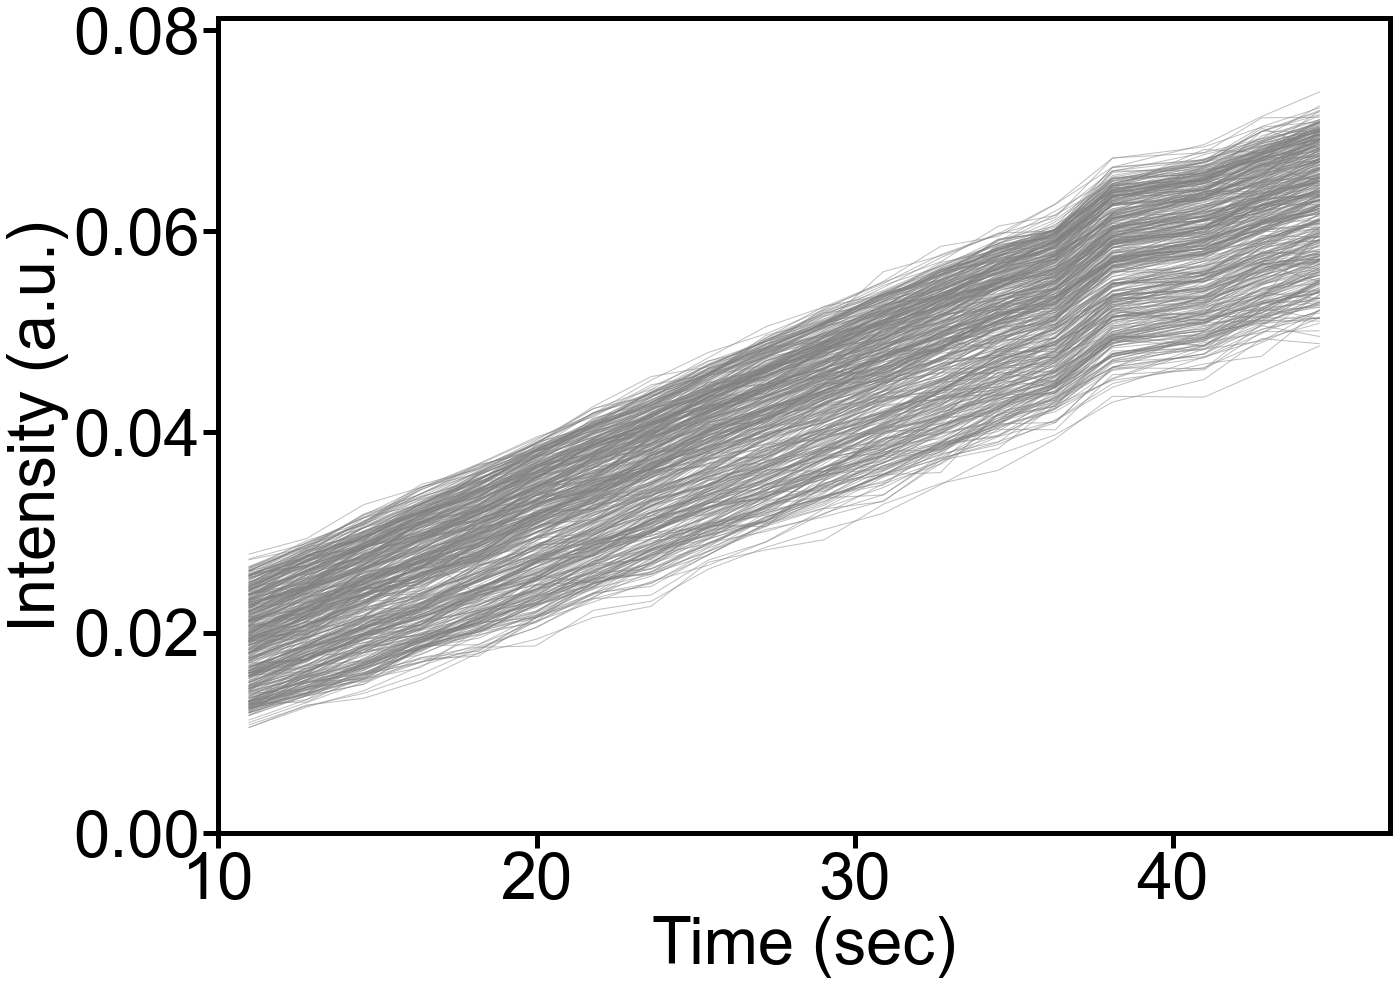

In [14]:
# import csv, get radius once and delete the column
data = pd.read_csv("Kinetics_230202_014.csv", delimiter=';')
time = pd.read_csv("014_Time.csv", delimiter=';')


# rename the columns
data.rename(columns = {'TRACK_ID': 'Droplet_ID', 'POSITION_X': 'X',  'POSITION_Y': 'Y' , 'POSITION_T': 'Time', 'MEAN_INTENSITY_CH1': 'ROX', 'MEAN_INTENSITY_CH2': 'Atto'}, inplace = True)

# group data by Droplet_ID
grouped = data.groupby(data.Droplet_ID)

# create a list of the droplet IDs
ID_list =[]
for i in data.Droplet_ID:
    ID_list.append(i) if i not in ID_list else ID_list
    
    
time_dict = time.set_index('Index').to_dict()['Time [s]']
data['Time'] = data['Time'].map(time_dict).fillna(data['Time'])

#create a list of the droplets, sort by time, normalize Signal and provide time in minutes
data_new=[]    
for i in range(len(ID_list)):
    data_new.append(grouped.get_group(ID_list[i]).sort_values(by=["Time"]))
    data_new[i]['Time'] = data_new[i]['Time']    
    data_new[i]['normalized'] = data_new[i]['ROX']/data_new[i]['Atto']

spikers = []
for item in data_new:
    for i in range(1,len(item["normalized"])):
        if abs(item["normalized"].iloc[i] - item["normalized"].iloc[i-1]) > 0.1*max(item["normalized"]):
            spikers.append(item["Droplet_ID"].iloc[0])    
    
data_new = [item for item in data_new if item["Droplet_ID"].iloc[0] not in spikers]
data_plot = data_new
before = len(data_new)

X_List = []
Y_List = []
for i in range(len(data_new)):   
    X_List.append(data_new[i]['X'].iloc[-1])
    Y_List.append(data_new[i]['Y'].iloc[-1])

lower_percentile = 5
upper_percentile = 95

# Calculate the percentile values
lower_threshold = np.percentile(X_List, lower_percentile)
upper_threshold = np.percentile(X_List, upper_percentile)

# Filter the list using list comprehension
New_X = [x for x in X_List if x > lower_threshold and x < upper_threshold]

lower_threshold = np.percentile(Y_List, lower_percentile)
upper_threshold = np.percentile(Y_List, upper_percentile)

New_Y = [y for y in Y_List if y > lower_threshold and y < upper_threshold]


data_new = [item for item in data_new if item['X'].iloc[-1] in New_X and item['Y'].iloc[-1] in New_Y]

after= len(data_new)

min_list=[]
for i in range(len(data_new)):
    for j in range(len(data_new[i]['Time'])):
        if data_new[i]['Time'].iloc[j] >= 10:
            min_list.append(j)
            break


max_list=[]
for i in range(len(data_new)):
    for j in range(len(data_new[i]['Time'])):
        if data_new[i]['Time'].iloc[j] >= 46:
            max_list.append(j)
            break



slopes = []
LastGFP = []
for i in range(len(data_new)):   
    data_new[i] = data_new[i][min_list[i]:max_list[i]]
    dT = data_new[i]['Time'].iloc[-1] - data_new[i]['Time'].iloc[0]
    dF = data_new[i]['normalized'].iloc[-1] - data_new[i]['normalized'].iloc[0]
    slope = dF/dT
    slopes.append(slope)
    LastGFP.append(data_new[i]['Atto'].iloc[-1])
    

    
mean = stat.mean(slopes)
stdev = stat.stdev(slopes)

with open(r'Slopes_014_noRP.txt', 'w') as fp:
    for item in slopes:
        fp.write("%s\n" % item)
        
with open(r'GFP_014_noRP.txt', 'w') as fp:
    for item in LastGFP:
        fp.write("%s\n" % item)



duration = []
values = []
for i in data_new:
    plt.plot(i.Time, i.normalized, color='grey', linewidth=1, linestyle='-', alpha=0.5, zorder=0)
    duration.append(max(i.Time))
    values.append(max(i.normalized))

plt.xlabel('Time (sec)', fontsize=65)
plt.ylabel('Intensity (a.u.)', fontsize=65)
plt.axis([10,max(duration)+0.05*max(duration), 0, max(values)+0.1*max(values)])
plt.tick_params(axis='both', length=15, width=5)
plt.savefig("Slope.png",dpi=100, format='png')

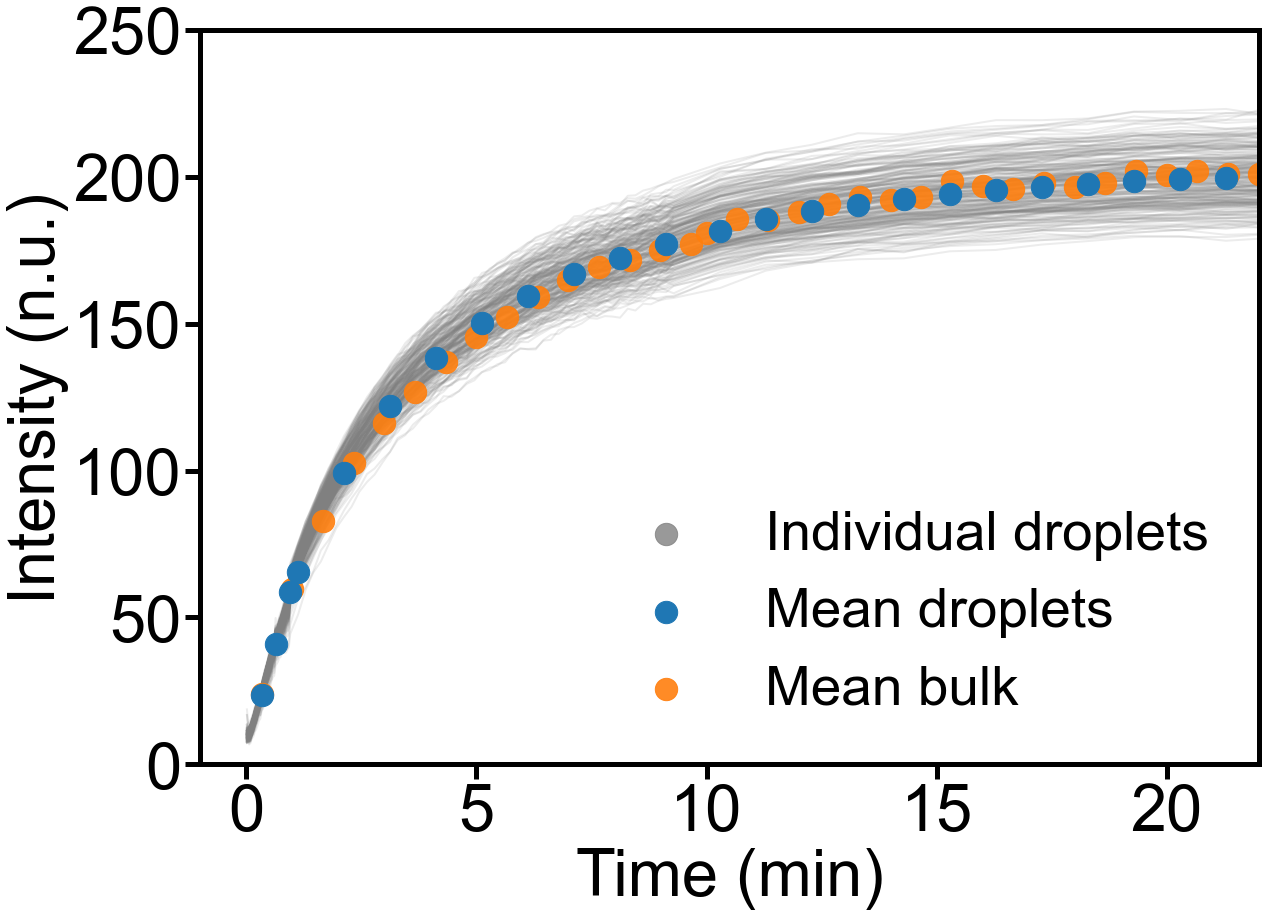

In [15]:
duration = []
values = []

for i in data_plot:
    plt.plot(i.Time, i.normalized, color='grey', linewidth=1, linestyle='-', alpha=0.2, zorder=0)
    duration.append(max(i.Time))
    values.append(max(i.normalized))

mean = []
asum = 0
    
data_plot = [item for item in data_plot if len(item) == 94]
for i in range(len(data_plot[0]["normalized"])):
    for j in data_plot:
        asum += (j.normalized.iloc[i])
    mean.append(asum/len(data_plot))
    asum = 0
    
mean_new = [item/mean[-1]*200 for item in mean]

    
smoothed_mean = pd.Series(mean_new).rolling(window=2, center=True).mean()    

plt.scatter([], [], color='grey', s=500, alpha=0.8, zorder=0, label = 'Individual droplets')
plt.scatter(data_plot[0]['Time'][0:31][::10]/60, smoothed_mean[0:31][::10], color = 'tab:blue', zorder = 2, s=500)
plt.scatter(data_plot[0]['Time'][31:81][::6]/60, smoothed_mean[31:81][::6], color = 'tab:blue', zorder = 2, s=500)
plt.scatter(data_plot[0]['Time'][81:]/60, smoothed_mean[81:], color = 'tab:blue', zorder = 2, s=500, label='Mean droplets')


for i in data_plot:
    plt.plot(i.Time/60, i.normalized*200/mean[-1], color='grey', linewidth=2, linestyle='-', alpha=0.15, zorder=0)
    duration.append(max(i.Time))
    values.append(max(i.normalized*200/mean[-1]))

    
    

data_bulk = pd.read_csv("Bulk-withoutRP.csv", delimiter=';')


plt.scatter(data_bulk['time'][20:600][::40]/60, data_bulk['bulk'][20:600][::40], color = 'tab:orange', s=500, alpha = 0.9, zorder = 1)
plt.scatter(data_bulk['time'][600:][::4]/60, data_bulk['bulk'][600:][::4], color = 'tab:orange', s=500, alpha = 0.9, zorder = 1, label='Mean bulk') 
plt.xlabel('Time (min)', fontsize=65)
plt.ylabel('Intensity (n.u.)', fontsize=65)
plt.axis([-1,22, 0,250])
plt.legend(fontsize=55, loc=0, frameon = False)
plt.tick_params(axis='both', length=15, width=5)
#plt.title('Invader (toe 5)', fontsize=55)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)
plt.savefig("All.svg",dpi=100, format='svg')